Dataset obtained from NCBI Gene Expression Omnibus:  https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE184635

Title: Reprogramming of ovarian aging epigenome by resveratrol [RNA-seq]

Summary: 	Depletion of oocytes and follicles and reduced oocyte quality contribute to age-associated ovarian senescence and infertility. Resveratrol acts as anti-oxidant and Sirt1 activator to alleviate aging including reproductive aging. It remains elusive whether resveratrol can reprogram the aging epigenome. We sought to examine aging ovarian epigenome and the potential effects of resveratrol by combined analysis of transcriptome and methylome mainly in oocytes and also in granulosa cells, two major cell types in the ovary.

Objective: Cluster RNA-seq data in mice oocytes with/without resveratrol to examine its impact on the aging transcriptome

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import re
import umap
from sklearn.model_selection import GridSearchCV, KFold
import seaborn as sns
from sklearn.mixture import GaussianMixture


c:\Users\Kristin\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Kristin\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Kristin\AppData\Local\Programs\Python\P

In [2]:
df = pd.read_csv("C:/Users/Kristin/Desktop/Thinkful/capstone3/GSE184635_RNAseq-counts-1.csv")

Only select one cell type (oocyte) for this analysis, data obtained from granulosa cells (GCs) are removed.

In [3]:
# select only the columns(samples) from oocytes
df_oo = df.loc[:, ~df.columns.str.startswith('GC_')]

In [4]:
# select all the column names 
gp_columns = df_oo.columns[1:]

We are only interested in assessing the effects of resveratrol in wildtype (not geneticaly modified) mice. Hence, samples from knockout mice are also removed.

In [5]:
# remove samples from knockout animals
columns_to_be_removed = []
for column in gp_columns:
    if 'KO' in str(column):
        columns_to_be_removed.append(column)

In [6]:
WT_oo_df = df_oo.drop(columns=columns_to_be_removed)

In [7]:
wt_columns = WT_oo_df.columns[1:]

Add labels (Y-axis) to the dataset based on experimental conditions

Experiment design and abbreviations
"MWTC"for middle-age(6-month-old) WT control group
"MWTR"for middle-age(6-month-old) WT resveratrol treated group
"OWTC"for old age(10-month-old) WT control group
"OWTR"for old age(10-month-old) WT resveratrol treated group
"YWT"for young(2-month-old) WT control group

In [8]:
age_dict = {
     'MWTC': 1,
     'MWTR': 2,
     'OWTC': 3,
     'OWTR': 4,
     'YWT': 0
}

In [9]:
# extract the string in the sample ID to classify mice based on 1) age: young (2mo), middle-aged (6mo) and old (10mo)
# and 2) resveratrol treatment
age_groups = []
for column in wt_columns:
    age = re.match(r'(\D+)', column).group()
    age_groups.append(age)

In [10]:
# add age row to the dataframe
row_w_age = pd.DataFrame([age_groups], columns= WT_oo_df.columns[1:])

WT_oo_df = pd.concat([WT_oo_df, row_w_age], ignore_index=True)

In [11]:
# relabel the age row based on "age dict"
last_row = WT_oo_df.index[-1]
for column in WT_oo_df.columns[1:]:
    WT_oo_df.loc[last_row, column] = age_dict.get(WT_oo_df.loc[last_row, column], WT_oo_df.loc[last_row, column])

In [12]:
WT_oo_df

,Unnamed: 0,YWT1.10,YWT1.11,YWT1.12,YWT1.1,YWT1.2,YWT1.3,YWT1.4,YWT1.5,YWT1.6,...,OWTC1.11,OWTC2.1,OWTC2.2,OWTC2.3,OWTC2.4,OWTC2.5,OWTC2.6,OWTC2.7,OWTC2.8,OWTC2.9
0,Gnai3,1464,1476,1399,2015,1970,1155,1461,1871,1790,...,1516,1103,1051,870,1543,1055,1038,1113,1101,1093
1,Pbsn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cdc45,531,575,504,673,493,437,452,574,505,...,644,519,599,494,716,596,486,416,505,583
3,H19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Scml2,1035,890,1083,1198,955,808,852,1162,1098,...,712,907,1259,1168,1023,1222,1053,869,891,1299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53615,RP23-125E11.1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,4
53616,RP24-167O15.2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53617,RP24-97D3.1,2,0,4,0,0,0,0,2,1,...,0,1,0,0,0,0,0,0,0,0
53618,RP23-171L7.4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# transform the dataframe so the samples become rows and gene become features
WT_oo_T = WT_oo_df.T

In [14]:
# name the age column as Y
WT_oo_T.iloc[0,-1] = "Y"

In [15]:
WT_oo_T

,0,1,2,3,4,5,6,7,8,9,...,53610,53611,53612,53613,53614,53615,53616,53617,53618,53619
Unnamed: 0,Gnai3,Pbsn,Cdc45,H19,Scml2,Apoh,Narf,Cav2,Klf6,Scmh1,...,RP23-25N17.6,RP24-261L5.4,RP24-216B4.6,RP23-32P19.4,RP23-459E13.2,RP23-125E11.1,RP24-167O15.2,RP24-97D3.1,RP23-171L7.4,Y
YWT1.10,1464,0,531,0,1035,0,82,0,1,276,...,98,0,0,0,78,1,0,2,0,0
YWT1.11,1476,0,575,0,890,0,46,0,6,254,...,120,0,0,0,41,0,0,0,0,0
YWT1.12,1399,0,504,0,1083,3,48,0,1,269,...,89,0,0,0,39,0,0,4,0,0
YWT1.1,2015,0,673,0,1198,1,75,0,0,212,...,77,0,0,0,76,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OWTC2.5,1055,0,596,0,1222,0,66,0,20,474,...,59,0,0,0,27,0,0,0,0,3
OWTC2.6,1038,0,486,0,1053,0,67,0,6,357,...,109,0,0,0,39,1,0,0,0,3
OWTC2.7,1113,0,416,0,869,0,44,0,2,277,...,111,0,0,3,34,0,0,0,0,3
OWTC2.8,1101,0,505,0,891,0,46,0,0,370,...,137,0,0,0,34,0,0,0,0,3


In [16]:
WT_oo_T.iloc[1:, -1].values # .iloc[] returns a dataframe and .values returns an array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
      dtype=object)

In [17]:
X = WT_oo_T.iloc[1:, :-1].values
Y = WT_oo_T.iloc[1:, -1].values

In [18]:
scaler = StandardScaler()

X_std = scaler.fit_transform(X)

In [19]:
# dimensionality reduction method 1
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_std)

In [20]:
# dimensionality reduction method 2
reducer = umap.UMAP(
    n_neighbors=12,
    min_dist=0.2
)
embedding = reducer.fit_transform(X_std)

Text(0.5, 1.0, 'dimension reduction -- PCA')

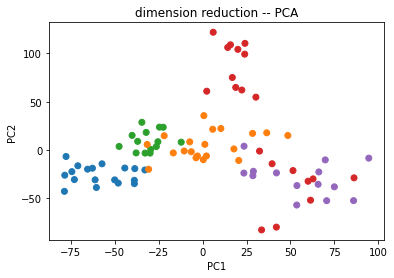

In [21]:
# visualization -- PCA
plt.scatter(
    pca_components[:, 0],
    pca_components[:,1],
    c= [sns.color_palette()[identifier] for identifier in Y]
    )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('dimension reduction -- PCA')

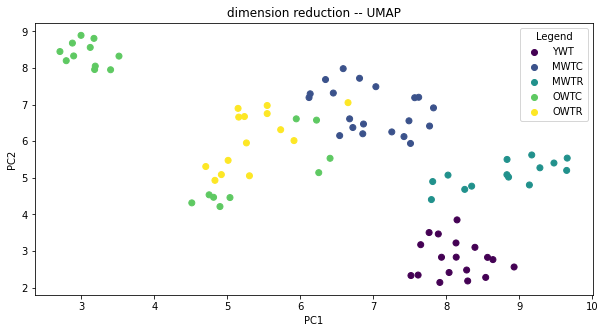

In [22]:
plt.figure(figsize=(10,5))
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:,1],
    c=Y,
    cmap='viridis'
    )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('dimension reduction -- UMAP')

# Create a legend
legend_labels = ['YWT', 'MWTC', 'MWTR', 'OWTC', 'OWTR']  # Replace with actual labels corresponding to Y array
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Legend')


In [23]:
# clustering with KMeans using pca dimension reduced input data
k_means = KMeans(n_clusters=5)
k_means.fit(pca_components)
pca_clusters = k_means.predict(pca_components)

c:\Users\Kristin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
# clustering with KMeans using umap dimension reduced input data
k_means.fit(embedding)
umap_clusters = k_means.predict(embedding)

c:\Users\Kristin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Evaluating clusters: UMAP-reduced data has higher Rand index and silhouette score after KMeans clustering when compared to PCA reduced data


In [25]:
# evaluating Kmeans clustering performance using pca
print("Adjusted Rand Index of the Agglomerative Clustering solution: {}"
.format(metrics.adjusted_rand_score(Y, pca_clusters)))
print("silhouette score of the agglomerative Clustering solution: {}"
.format(metrics.silhouette_score(pca_components, pca_clusters)))

Adjusted Rand Index of the Agglomerative Clustering solution: 0.5320168522136183
silhouette score of the agglomerative Clustering solution: 0.45191011198749176


In [26]:
# evaluating Kmeans clustering performance using umap
print("Adjusted Rand Index of the Agglomerative Clustering solution: {}"
.format(metrics.adjusted_rand_score(Y, umap_clusters)))
print("silhouette score of the agglomerative Clustering solution: {}"
.format(metrics.silhouette_score(embedding, umap_clusters)))

Adjusted Rand Index of the Agglomerative Clustering solution: 0.6353256391428396
silhouette score of the agglomerative Clustering solution: 0.584559977054596


In [27]:
# second clustering algorithm
ward_cluster_agg = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=3)
avg_cluster_agg = AgglomerativeClustering(linkage='average', affinity='cosine', n_clusters=3)
agg_cluster_complete_agg = AgglomerativeClustering(linkage='complete', affinity='cosine', n_clusters=3)

In [28]:
cluster_ward = ward_cluster_agg.fit_predict(pca_components)
cluster_avg = avg_cluster_agg.fit_predict(pca_components)
cluster_complete = agg_cluster_complete_agg.fit_predict(pca_components)

c:\Users\Kristin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\Kristin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\Kristin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [29]:
print("Adjusted Rand Index of agglomerative cluster: {}".format(
    metrics.adjusted_rand_score(Y, cluster_ward)
))
print("The silhouette score of agglomerative cluster: {}".format(
    metrics.silhouette_score(pca_components, cluster_ward, metric='euclidean')
))
print('----------------------------------------------')
print('Scores for linkage method = average')
print("Adjusted Rand Index of agglomerative cluster: {}".format(
    metrics.adjusted_rand_score(Y, cluster_avg)
))
print("the silhouette score of agglomerative cluster: {}".format(
    metrics.silhouette_score(pca_components, cluster_avg, metric='euclidean')
))

print('-----------------------------------------------')
print('Scores for linkage method complete')
print("Adjusted Rand Index of agglomerative cluster: {}".format(
    metrics.adjusted_rand_score(Y, cluster_complete)
))
print("the silhouette score of agglomerative cluster: {}".format(
    metrics.silhouette_score(pca_components, cluster_complete, metric='euclidean')
))

Adjusted Rand Index of agglomerative cluster: 0.29918045461574144
The silhouette score of agglomerative cluster: 0.5488071959984524
----------------------------------------------
Scores for linkage method = average
Adjusted Rand Index of agglomerative cluster: 0.28900444645414125
the silhouette score of agglomerative cluster: 0.5141798000649634
-----------------------------------------------
Scores for linkage method complete
Adjusted Rand Index of agglomerative cluster: 0.29108853458171463
the silhouette score of agglomerative cluster: 0.22392639264130004


In [30]:
# using umap reduced data as input
cluster_ward = ward_cluster_agg.fit_predict(embedding)
cluster_avg = avg_cluster_agg.fit_predict(embedding)
cluster_complete = agg_cluster_complete_agg.fit_predict(embedding)

c:\Users\Kristin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\Kristin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\Kristin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [31]:
print("Adjusted Rand Index of agglomerative cluster: {}".format(
    metrics.adjusted_rand_score(Y, cluster_ward)
))
print("The silhouette score of agglomerative cluster: {}".format(
    metrics.silhouette_score(embedding, cluster_ward, metric='euclidean')
))
print('----------------------------------------------')
print('Scores for linkage method = average')
print("Adjusted Rand Index of agglomerative cluster: {}".format(
    metrics.adjusted_rand_score(Y, cluster_avg)
))
print("the silhouette score of agglomerative cluster: {}".format(
    metrics.silhouette_score(embedding, cluster_avg, metric='euclidean')
))

print('-----------------------------------------------')
print('Scores for linkage method complete')
print("Adjusted Rand Index of agglomerative cluster: {}".format(
    metrics.adjusted_rand_score(Y, cluster_complete)
))
print("the silhouette score of agglomerative cluster: {}".format(
    metrics.silhouette_score(embedding, cluster_complete, metric='euclidean')
))

Adjusted Rand Index of agglomerative cluster: 0.4144225631468032
The silhouette score of agglomerative cluster: 0.5462731719017029
----------------------------------------------
Scores for linkage method = average
Adjusted Rand Index of agglomerative cluster: 0.4144225631468032
the silhouette score of agglomerative cluster: 0.5462731719017029
-----------------------------------------------
Scores for linkage method complete
Adjusted Rand Index of agglomerative cluster: 0.4144225631468032
the silhouette score of agglomerative cluster: 0.5462731719017029


In [32]:
gmm_cluster = GaussianMixture(n_components=5)
clusters = gmm_cluster.fit_predict(embedding)

In [33]:
# evaluating GMM clustering performance using umap
print("Adjusted Rand Index of the Agglomerative Clustering solution: {}"
.format(metrics.adjusted_rand_score(Y, clusters)))
print("silhouette score of the agglomerative Clustering solution: {}"
.format(metrics.silhouette_score(embedding, clusters)))

Adjusted Rand Index of the Agglomerative Clustering solution: 0.6107026973608358
silhouette score of the agglomerative Clustering solution: 0.5833166241645813


Dimension reduction method: UMAP is the better method based on evaluation metrics and data visualization, as seen from more distinct clusters in the graph.
Clustering algorithm: KMeans and Gaussian Mixture Model performed better than hierarchial clustering.
The clustering results supports the aging transcriptome theory (i.e., transcriptome changes with age). In addition, resveratrol to have impact on the transcriptome, especially in middle-aged mice, since the gene expression data obtained from middle-aged resveratrol-treated mice oocytes is distinct from that of non-treated mice. On the other hand, resveratrol's impact of old mice is not as clear.